#What is clustering
Clustering is an unsupervised learning technique, in short, you are working on data, without having any information about a target attribute or a dependent variable. The general idea of clustering is to find some intrinsic structure in the data, often referred to as groups of similar objects. The algorithm studies the data to identify these patterns or groups such that each member in a group is closer to another member in the group (lower intracluster distance) and farther from another member in a different group (higher inter-cluster distance)


**Examples**


*   Customer Segmentation — Used widely for targeted marketing
*   Recommendation Engines





#Setting up PySpark in Colab
Spark is written in the Scala programming language and requires the Java Virtual Machine (JVM) to run. Therefore, our first task is to download Java.


In [ ]:
!apt-get install openjdk-8-jdk-headless

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openjdk-8-jdk-headless is already the newest version (8u312-b07-0ubuntu1~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


Now install Spark 3.2.1 with Hadoop 2.7

In [ ]:
!wget https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz


--2022-05-18 16:21:47--  https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
Resolving archive.apache.org (archive.apache.org)... 138.201.131.134, 2a01:4f8:172:2ec5::2
Connecting to archive.apache.org (archive.apache.org)|138.201.131.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 272637746 (260M) [application/x-gzip]
Saving to: ‘spark-3.2.1-bin-hadoop2.7.tgz’

spark-3.2.1-bin-had 100%[===================>] 260.01M  18.7MB/s    in 13s     

2022-05-18 16:22:01 (19.3 MB/s) - ‘spark-3.2.1-bin-hadoop2.7.tgz’ saved [272637746/272637746]



 we just need to unzip that folder.


In [ ]:
!tar xf /content/spark-3.2.1-bin-hadoop2.7.tgz


There is one last thing that we need to install and that is the findspark library. It will locate Spark on the system and import it as a regular library.


In [ ]:
!pip install -q findspark


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"

We need to locate Spark in the system. For that, we import findspark and use the findspark.init() method.

In [ ]:
import findspark
findspark.init()
findspark.find()

'/content/spark-3.2.1-bin-hadoop2.7'

Now that we have installed all the necessary dependencies in Colab, it is time to set the environment path. This will enable us to run Pyspark in the Colab environment.

In [ ]:
import pyspark
import numpy as np
import pandas as pd

## Data Preparation

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master('local[*]').appName('Customer_Segmants').getOrCreate()

# Read data from CSV file
#you can download it from here:   https://raw.githubusercontent.com/besherh/BigDataManagement/main/SparkCSV/CC_GENERAL.csv
customer_df=spark.read.csv('/content/combined-data.csv', header=True, inferSchema=True)

customer_df.show(5)
customer_df.describe().toPandas()

+------+-------------+---------+------------+----------------+----------+-----------+---------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|
+------+-------------+---------+------------+----------------+----------+-----------+---------+
|   812|         5648|        1|     android|              69|         8|       NULL|     NULL|
|  1658|         5649|        1|      iphone|              31|         5|       NULL|     NULL|
|  1589|         5650|        1|      iphone|              26|         2|       NULL|     NULL|
|  1863|         5651|        1|     android|              35|         4|       NULL|     NULL|
|   937|         5652|        1|     android|              39|         0|          1|     1.00|
+------+-------------+---------+------------+----------------+----------+-----------+---------+
only showing top 5 rows



,summary,userId,userSessionId,teamLevel,platformType,count_gameclicks,count_hits,count_buyId,avg_price
0,count,4619,4619,4619,4619,4619,4619,4619,4619
1,mean,1189.9647109764019,17963.06798008227,4.355704697986577,None,143.06300064949124,15.705780471963628,1.6832034018426647,7.214323175053155
2,stddev,691.0986309664246,7947.681126803095,1.9246625516949587,None,126.88339694316925,13.986901900918744,0.9005088871085436,6.536501375588665
3,min,0,5648,1,android,1,0,1,1.00
4,max,2389,38722,8,windows,1207,121,NULL,NULL


#Data Schema

In [ ]:
customer_df.printSchema()


root
 |-- userId: integer (nullable = true)
 |-- userSessionId: integer (nullable = true)
 |-- teamLevel: integer (nullable = true)
 |-- platformType: string (nullable = true)
 |-- count_gameclicks: integer (nullable = true)
 |-- count_hits: integer (nullable = true)
 |-- count_buyId: string (nullable = true)
 |-- avg_price: string (nullable = true)



In [ ]:

from pyspark.sql.types import IntegerType

# Number of records with missing 'delay' values
customer_df.filter('avg_price IS NULL').count()

# Remove records with missing 'delay' values
customer_df = customer_df.filter(customer_df.avg_price != "NULL")

# Remove records with missing values in any column and get the number of remaining rows
customer_df = customer_df.dropna()

customer_df = customer_df.withColumn("avg_price", customer_df["avg_price"].cast(IntegerType()))

customer_df.show(5)
customer_df.describe().toPandas()

+------+-------------+---------+------------+----------------+----------+-----------+---------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|
+------+-------------+---------+------------+----------------+----------+-----------+---------+
|   937|         5652|        1|     android|              39|         0|          1|        1|
|  1623|         5659|        1|      iphone|             129|         9|          1|       10|
|    83|         5661|        1|     android|             102|        14|          1|        5|
|   121|         5665|        1|     android|              39|         4|          1|        3|
|   462|         5666|        1|     android|              90|        10|          1|        3|
+------+-------------+---------+------------+----------------+----------+-----------+---------+
only showing top 5 rows



,summary,userId,userSessionId,teamLevel,platformType,count_gameclicks,count_hits,count_buyId,avg_price
0,count,1411,1411,1411,1411,1411,1411,1411,1411
1,mean,1201.0751240255138,19166.43869596031,4.834160170092133,None,145.23458540042523,16.758327427356484,1.6832034018426647,7.114812189936216
2,stddev,691.9957569853385,7451.158753782938,1.7914678556629045,None,119.76291399660911,13.565930146754264,0.9005088871085436,6.533677101892512
3,min,1,5652,1,android,6,0,1,1
4,max,2387,38321,7,windows,982,100,6,20


In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import IntegerType
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import StringIndexer

# Create an indexer
indexer = StringIndexer(inputCol='platformType', outputCol='platformType_idx')

# Indexer identifies categories in the data
indexer_model = indexer.fit(customer_df)

# Indexer creates a new column with numeric index values
customer_df = indexer_model.transform(customer_df)

customer_df.columns
assemble=VectorAssembler(inputCols=[
 'platformType_idx',
 'count_gameclicks',
 'avg_price'], outputCol='features')
assembled_data=assemble.transform(customer_df)
assembled_data.show(2)

+------+-------------+---------+------------+----------------+----------+-----------+---------+----------------+----------------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|platformType_idx|        features|
+------+-------------+---------+------------+----------------+----------+-----------+---------+----------------+----------------+
|   937|         5652|        1|     android|              39|         0|          1|        1|             1.0|  [1.0,39.0,1.0]|
|  1623|         5659|        1|      iphone|             129|         9|          1|       10|             0.0|[0.0,129.0,10.0]|
+------+-------------+---------+------------+----------------+----------+-----------+---------+----------------+----------------+
only showing top 2 rows



In [ ]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='scaled_features')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show(2)


+------+-------------+---------+------------+----------------+----------+-----------+---------+----------------+----------------+--------------------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|platformType_idx|        features|     scaled_features|
+------+-------------+---------+------------+----------------+----------+-----------+---------+----------------+----------------+--------------------+
|   937|         5652|        1|     android|              39|         0|          1|        1|             1.0|  [1.0,39.0,1.0]|[0.95765670056880...|
|  1623|         5659|        1|      iphone|             129|         9|          1|       10|             0.0|[0.0,129.0,10.0]|[0.0,1.0771280999...|
+------+-------------+---------+------------+----------------+----------+-----------+---------+----------------+----------------+--------------------+
only showing top 2 rows



In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='scaled_features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='scaled_features', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    score=evaluator.evaluate(output)
    silhouette_score.append(score)
    print(f"Silhouette Score k{i}:",round(score, 2))

Silhouette Score k2: 0.56
Silhouette Score k3: 0.62
Silhouette Score k4: 0.61
Silhouette Score k5: 0.53
Silhouette Score k6: 0.55
Silhouette Score k7: 0.58
Silhouette Score k8: 0.59
Silhouette Score k9: 0.56


Text(0, 0.5, 'Silhouette Score')

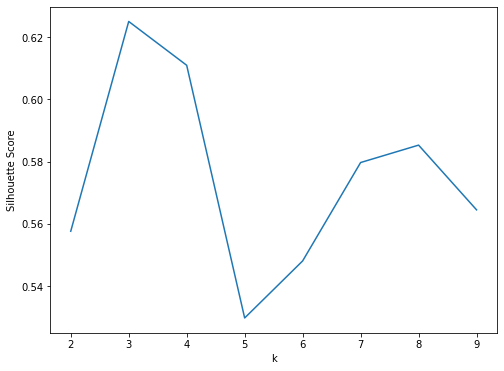

In [ ]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('Silhouette Score')


Highest value when k = 3


In [ ]:
final_clustering=KMeans(featuresCol='scaled_features', k=3)
KMeans_fit=KMeans_algo.fit(data_scale_output)
clusters_output=KMeans_fit.transform(data_scale_output)


In [ ]:
#notice the last column [prediction]
clusters_output.show()


+------+-------------+---------+------------+----------------+----------+-----------+---------+----------------+----------------+--------------------+----------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|platformType_idx|        features|     scaled_features|prediction|
+------+-------------+---------+------------+----------------+----------+-----------+---------+----------------+----------------+--------------------+----------+
|   937|         5652|        1|     android|              39|         0|          1|        1|             1.0|  [1.0,39.0,1.0]|[0.95765670056880...|         5|
|  1623|         5659|        1|      iphone|             129|         9|          1|       10|             0.0|[0.0,129.0,10.0]|[0.0,1.0771280999...|         0|
|    83|         5661|        1|     android|             102|        14|          1|        5|             1.0| [1.0,102.0,5.0]|[0.95765670056880...|         5|
|   121|         5665|      

In [ ]:
from pyspark.ml.feature import PCA as PCAml
pca = PCAml(k=3, inputCol="scaled_features", outputCol="pca")
pca_model = pca.fit(data_scale_output)
pca_transformed = pca_model.transform(data_scale_output)
pca_transformed.show(2)

+------+-------------+---------+------------+----------------+----------+-----------+---------+----------------+----------------+--------------------+--------------------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|platformType_idx|        features|     scaled_features|                 pca|
+------+-------------+---------+------------+----------------+----------+-----------+---------+----------------+----------------+--------------------+--------------------+
|   937|         5652|        1|     android|              39|         0|          1|        1|             1.0|  [1.0,39.0,1.0]|[0.95765670056880...|[-0.5920825753709...|
|  1623|         5659|        1|      iphone|             129|         9|          1|       10|             0.0|[0.0,129.0,10.0]|[0.0,1.0771280999...|[0.99763793762722...|
+------+-------------+---------+------------+----------------+----------+-----------+---------+----------------+----------------+-----------

In [ ]:
import numpy as np
x_pca = np.array(pca_transformed.rdd.map(lambda row: row.pca).collect())

In [ ]:
cluster_assignment = np.array(clusters_output.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

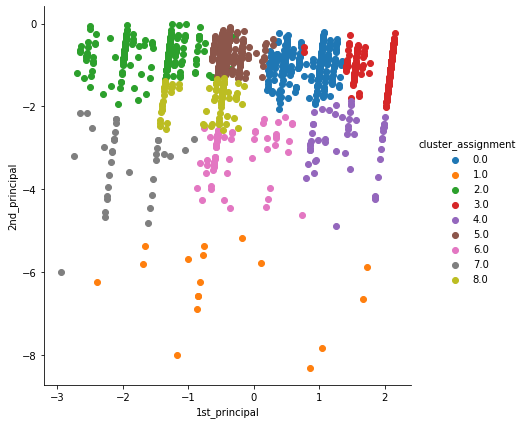

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

pca_data = np.hstack((x_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "3rd_principal","cluster_assignment"))

pca_df

sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()

plt.show()